In [1]:
#!pip install xgboost

In [2]:
#!pip install lightgbm

In [18]:
#import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import lightgbm as lgb

# Data Missing Value Treatment
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score

from sklearn.metrics import r2_score #accuracy_score, roc_auc_score

from sklearn.model_selection import GroupKFold
from sklearn import metrics


#Understanding each variable role given in Data with help of Diagram:-
1)	id - globally-unique time step identifier across an entire file

2)	breath_id - globally-unique time step for breaths

3)	R :- lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow. Normal airway resistance is estimated at 2 to 3 cm H2O/L/sec.

4)	 C:- Lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow. 

Both lung characteristics, control how the lungs would responds to the influx of air.  

5)	u_in: variable indicating the percentage of the input valve open, can be seen analogous to the volume of air let inside the lungs. The first control input (u_in )(Inspiratory Valve Green) is a continuous variable from 0 to 100 representing the percentage the inspiratory solenoid valve is open to let air into the lung (i.e., 0 is completely closed and no air is let in and 100 is completely open).
6)	u_out : The second control input is a binary variable representing whether the exploratory valve (Blue i.e. u_out )  is open (1) or closed (0) to let air out.

7)	time_step - the actual time stamp.

8)	pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O
It is measured in centimeters of water pressure (cm H2O)


# Importing Data set and Understanding Data

In [19]:
import os
os.getcwd()

'C:\\Users\\rajes\\Desktop\\BYOP Group I'

In [20]:
path = '/Users/sameerkumar/Python Tutorial/BYOP Project'

In [21]:
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))

In [22]:
pd.DataFrame({'Rows':[train.shape[0],test.shape[0]], 'Columns':[train.shape[1], test.shape[1]]},
                  index = ['Train Dataset', 'Test Dataset'])


,Rows,Columns
Train Dataset,6036000,8
Test Dataset,4024000,7


In [7]:
train.head(10)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
5,6,1,20,50,0.169698,27.259866,0,12.867706
6,7,1,20,50,0.203708,27.127486,0,14.695562
7,8,1,20,50,0.237723,26.807732,0,15.890699
8,9,1,20,50,0.271776,27.864715,0,15.539188
9,10,1,20,50,0.305732,28.313036,0,15.750094


In [8]:
train.tail(10)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
6035990,6035991,125749,50,10,2.337683,1.367263,1,4.009636
6035991,6035992,125749,50,10,2.371120,1.362261,1,4.009636
6035992,6035993,125749,50,10,2.404458,1.357586,1,4.009636
6035993,6035994,125749,50,10,2.437786,1.353205,1,4.009636
6035994,6035995,125749,50,10,2.471192,1.420711,1,3.939334
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938
6035999,6036000,125749,50,10,2.638017,1.482739,1,3.869032


In [9]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [11]:
test.head(10)

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0
5,6,0,5,20,0.159557,30.486938,0
6,7,0,5,20,0.191471,33.545950,0
7,8,0,5,20,0.223402,35.717600,0
8,9,0,5,20,0.255337,36.971061,0
9,10,0,5,20,0.287230,37.542219,0


# Finding Missing Value

In [12]:
train.isnull().sum()
test.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64

In [13]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [14]:
import missingno as msno

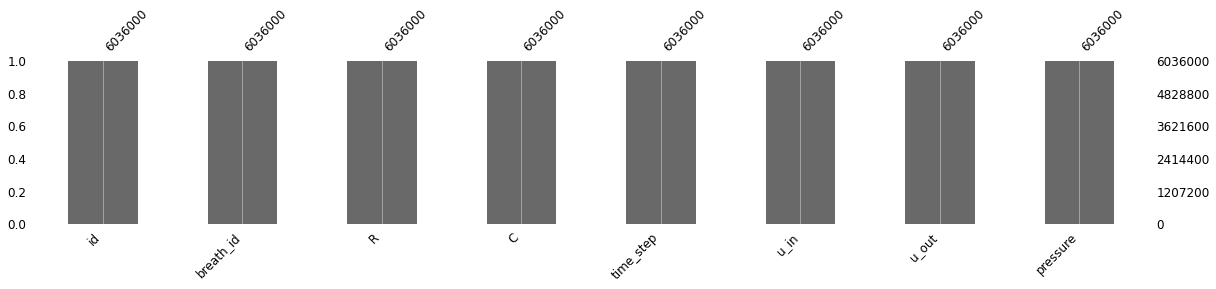

In [15]:
msno.bar(train, figsize = (20,3), fontsize = 12)
plt.grid();

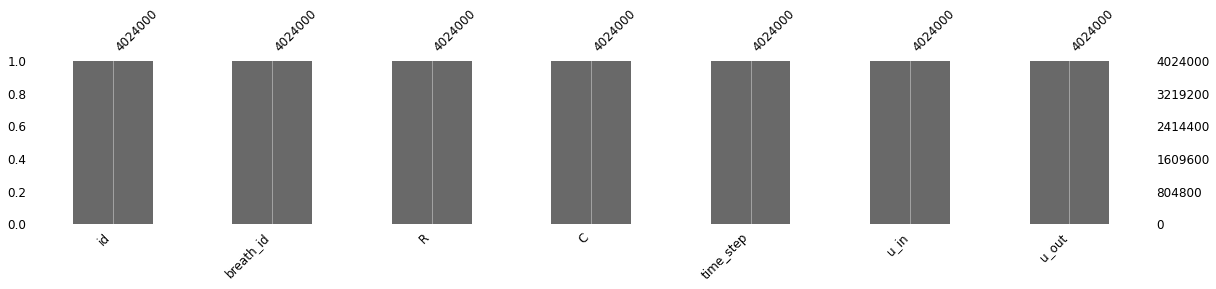

In [16]:
msno.bar(test, figsize=(20,3),fontsize=12)
plt.grid();

# In data no missing values are been observed

Duplicate Records in both data set

In [25]:
train.duplicated().sum()

0

In [26]:
test.duplicated().sum()

0

In [27]:
train.duplicated().value_counts()

False    6036000
dtype: int64

# Exploratory Data Analysis

In [18]:
train['time_step'].value_counts()

0.000000    75450
0.031934       46
0.031935       44
0.031920       43
0.031938       43
            ...  
1.252204        1
2.262712        1
2.237243        1
2.252335        1
0.289541        1
Name: time_step, Length: 3767571, dtype: int64

In [19]:
train['u_in'].value_counts()

0.000000      1432253
100.000000      21739
1.277707           76
1.494747           70
0.058727           67
               ...   
2.798517            1
4.527380            1
24.749642           1
4.035597            1
4.968208            1
Name: u_in, Length: 4020300, dtype: int64

In [20]:
train['u_out'].value_counts()

1    3745032
0    2290968
Name: u_out, dtype: int64

In [21]:
train['breath_id'].value_counts()

16392     80
113328    80
72363     80
96935     80
92837     80
          ..
71011     80
62815     80
46423     80
38227     80
4094      80
Name: breath_id, Length: 75450, dtype: int64

In [23]:
train['R'].value_counts()

50    2410080
5     1988800
20    1637120
Name: R, dtype: int64

In [24]:
len(train['breath_id'].unique())

75450

In [25]:
train['C'].value_counts()

10    2244720
50    1971680
20    1819600
Name: C, dtype: int64

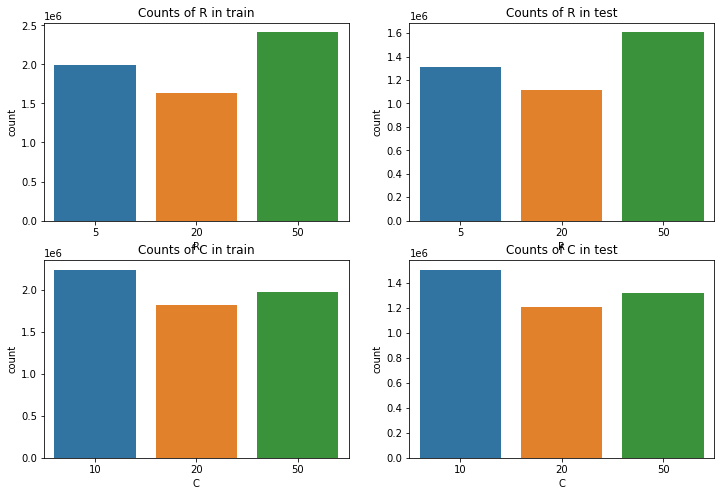

In [9]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.subplot(2, 2, 1)
sns.countplot(x='R', data=train)
plt.title('Counts of R in train');
plt.subplot(2, 2, 2)
sns.countplot(x='R', data=test)
plt.title('Counts of R in test');
plt.subplot(2, 2, 3)
sns.countplot(x='C', data=train)
plt.title('Counts of C in train');
plt.subplot(2, 2, 4)
sns.countplot(x='C', data=test)
plt.title('Counts of C in test');

In [26]:
train['pressure'].value_counts()
#Normal lung compliance is around 100 ml/cmH20
#Conversely, the administration of positive pressure of 5 cm H2O will generate an increase in lung volume of 500 mL

 6.399909     198642
 6.470211     188844
 6.329607     180688
 6.259305     180582
 6.610815     164401
               ...  
 62.711927         6
 62.641625         5
 63.274345         4
 62.360417         3
-1.895744          3
Name: pressure, Length: 950, dtype: int64

C:\Users\rajes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pressure'>

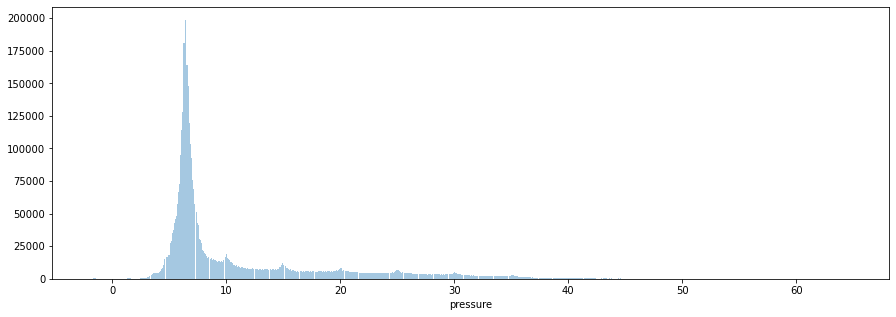

In [27]:
plt.figure(figsize = (15,5))
sns.distplot(train['pressure'],kde=False,bins=1000)

In [28]:
train.corr()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
id,1.000000,0.999999,0.001853,0.007222,-0.000199,-0.002380,-0.000089,-0.002402
breath_id,0.999999,1.000000,0.001860,0.007222,-0.000213,-0.002378,-0.000100,-0.002394
R,0.001853,0.001860,1.000000,-0.096070,-0.014535,-0.148120,-0.007594,0.015976
C,0.007222,0.007222,-0.096070,1.000000,0.004936,0.151002,0.003720,-0.036727
time_step,-0.000199,-0.000213,-0.014535,0.004936,1.000000,-0.352276,0.839191,-0.524829
u_in,-0.002380,-0.002378,-0.148120,0.151002,-0.352276,1.000000,-0.416985,0.308136
u_out,-0.000089,-0.000100,-0.007594,0.003720,0.839191,-0.416985,1.000000,-0.614910
pressure,-0.002402,-0.002394,0.015976,-0.036727,-0.524829,0.308136,-0.614910,1.000000


In [29]:
HM_train = train.copy()
HM_train.drop(['id'], axis = 1, inplace = True)

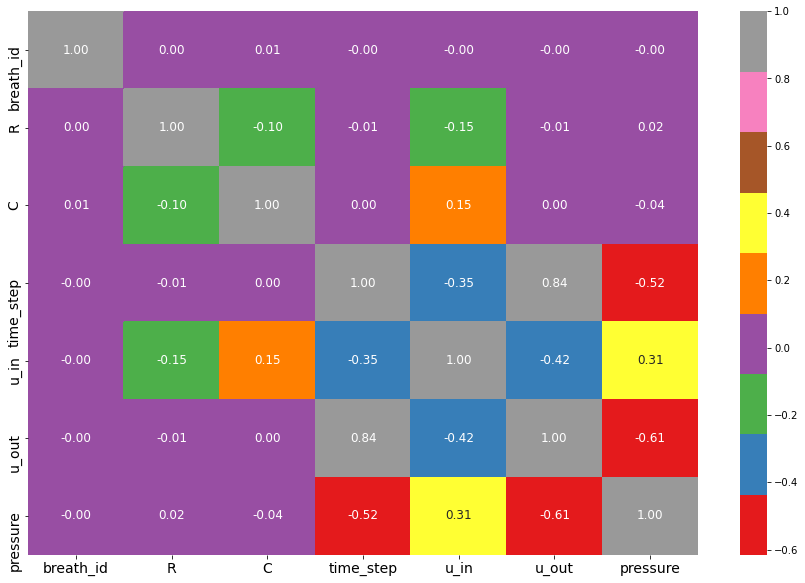

In [30]:
plt.figure(figsize = (15,10))
sns.heatmap(HM_train.corr(), annot = True, fmt = '3.2f' , annot_kws={'size' : 12}, cmap="Set1")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

Observations:-

1) Only the control input for the exploratory solenoid valve i.e. u_out, showing high positive correlation with time_step(84) and moderately negative correlation to Pressure(-61).
2) Pressure and time_step negatively correlated(-52).
3) u_in has positive correlation with pressure(31). Important to note its correlated to every variablesin dataset.
4) C&R not siginificantly correlated with any variables, though its do show correlation with u_in and cannot oversight.
5) breath_id do not show any correlation with any variables. Since its nuetral it better we drop this variables fm data. 

After evaluation of covariaent matrix its seems varibale ID & breath_id not much siginificant variable and lets drop from data

In [31]:
train.groupby("pressure")[['time_step','u_in','u_out','C','R']].agg(['min','max','mean']) 

time_step                           u_in                        \
                 min       max      mean        min        max       mean   
pressure                                                                    
-1.895744   0.300619  2.571832  1.647237   0.074548   0.519523   0.223554   
-1.825442   0.000000  2.638597  1.506164   0.000000   0.474771   0.116325   
-1.755140   0.000000  2.638705  1.477318   0.000000   0.778829   0.144561   
-1.684838   0.000000  2.638545  1.325082   0.000000   0.973513   0.169434   
-1.614536   0.000000  2.638074  1.336913   0.000000   0.931810   0.172052   
...              ...       ...       ...        ...        ...        ...   
 64.539783  0.289053  0.707320  0.498278  18.145218  45.938317  31.050581   
 64.610085  0.224439  0.579560  0.330840  20.322627  55.896150  41.628188   
 64.680387  0.225111  0.544988  0.398462  22.225579  54.207582  33.818024   
 64.750690  0.225200  0.610822  0.421672  21.639683  57.283838  37.182475   
 64.820992  0.192034  0.738674  0.410525   0.000000  62.927168  37.735088   

           u_out                 C                  R            
             min max      mean min max       mean min max  mean  
pressure                                                         
-1.895744      0   1  0.666667  10  10  10.000000  50  50  50.0  
-1.825442      0   1  0.724638  10  10  10.000000  50  50  50.0  
-1.755140      0   1  0.695853  10  10  10.000000  50  50  50.0  
-1.684838      0   1  0.626450  10  10  10.000000  50  50  50.0  
-1.614536      0   1  0.629820  10  10  10.000000  50  50  50.0  
...          ...  ..       ...  ..  ..        ...  ..  ..   ...  
 64.539783     0   0  0.000000  20  20  20.000000  50  50  50.0  
 64.610085     0   0  0.000000  20  20  20.000000  50  50  50.0  
 64.680387     0   0  0.000000  20  20  20.000000  50  50  50.0  
 64.750690     0   0  0.000000  20  20  20.000000  50  50  50.0  
 64.820992     0   0  0.000000  10  20  19.977038  50  50  50.0  

[950 rows x 15 columns]

Observation:-
Its been observed that pressure has total 950 combinations, this may have been occured in data because of different lungs characterstics at different time_step.

It means though Target variables seems continous in natuer in dataset, it is suitable to predecit with application of regression model and must look for additonal feature engneering. 

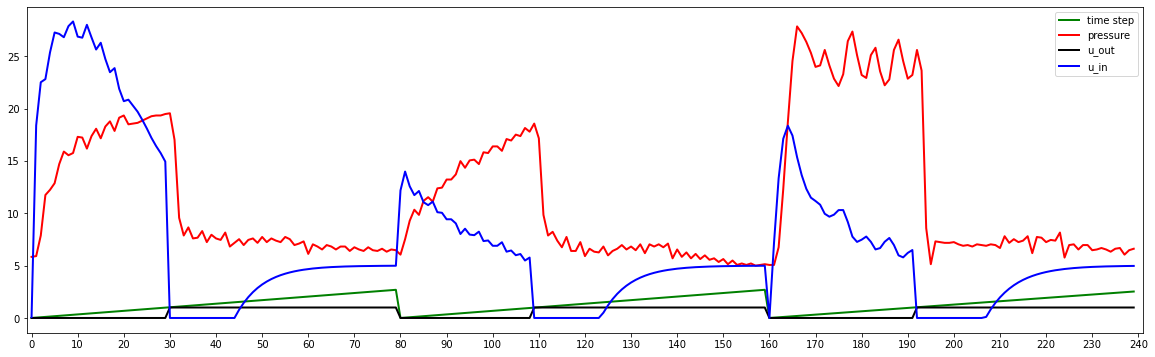

In [4]:
plt.figure(figsize = (20,6))
plt.plot(train.time_step[:240], linewidth = 2, color = 'g', label="time step")
plt.plot(train.pressure[:240],linewidth = 2, color = 'r', label="pressure")
plt.plot(train.u_out[:240], linewidth = 2, color = 'k', label="u_out")
plt.plot(train.u_in[:240], linewidth = 2, color = 'b', label="u_in")
plt.xticks(np.arange(0, 241,10))
plt.xlim([-1, 241])                        

plt.legend()
                        
plt.show()

Observation:-
1) Inspiratory length = 80 i.e. breath cycle is 80 unit long.

2) In every cycle, u_in raise sharp at 0 and then start decreasing. At 30 it falls sharp to 0 and remains at same from 30 to 50 unit and then raise exponentially and become constant till the end of the each breath cycle.

3) When its fall u_out increase upto 1 and stay constant till next 50 unit long. So toal u_in & u_out complets in 1 breath cycle of 80units.

4) Pressure raise when u_in triggered. It falls sharp after the fall of u_in to 0.

5) The pressure does not fall to 0 rather it hold the memory till the next trigger of u_in. Its remain constant in entire breathing proces at alomost 5point.

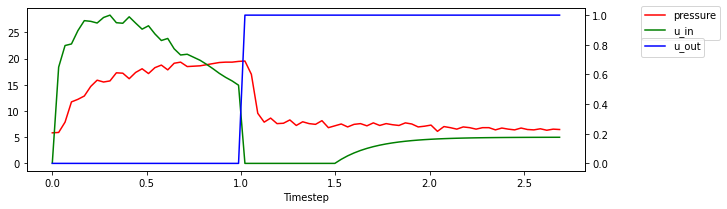

In [13]:
fig, ax1 = plt.subplots(figsize = (10, 3))

breath_1 = train.loc[train['breath_id'] == 1]
ax2 = ax1.twinx()

ax1.plot(breath_1['time_step'], breath_1['pressure'], 'r-', label='pressure')
ax1.plot(breath_1['time_step'], breath_1['u_in'], 'g-', label='u_in')
ax2.plot(breath_1['time_step'], breath_1['u_out'], 'b-', label='u_out')

ax1.set_xlabel('Timestep')

ax1.legend(loc=(1.1, 0.8))
ax2.legend(loc=(1.1, 0.7))
plt.show()

In [5]:
train=train.drop(['id'], axis = 1)
test=test.drop(['id'], axis = 1)

In [5]:
train.info()
print('====================================')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   breath_id  int64  
 1   R          int64  
 2   C          int64  
 3   time_step  float64
 4   u_in       float64
 5   u_out      int64  
 6   pressure   float64
dtypes: float64(3), int64(4)
memory usage: 322.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   breath_id  int64  
 1   R          int64  
 2   C          int64  
 3   time_step  float64
 4   u_in       float64
 5   u_out      int64  
dtypes: float64(2), int64(4)
memory usage: 184.2 MB


In [6]:
X = train.drop(columns=['pressure'],axis=1)
y = train['pressure']

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.30, random_state=1000)

In [8]:
print('Dimension of X_train:', X_train.shape,'\nDimension of X_validation:', X_validation.shape,'\nDimension of y_train:', y_train.shape,'\nDimension of y_validation:', y_validation.shape)

Dimension of X_train: (4225200, 6) 
Dimension of X_validation: (1810800, 6) 
Dimension of y_train: (4225200,) 
Dimension of y_validation: (1810800,)


# Building Model

**Linear Regression**

In [9]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

LinearRegression()

In [10]:
LR_train_predict = LR_model.predict(X_train)
LR_validation_predict = LR_model.predict(X_validation)

In [11]:
from yellowbrick.regressor import PredictionError

C:\Users\rajes\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


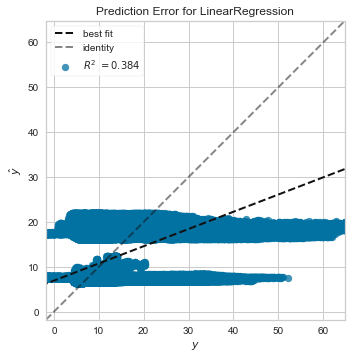

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [12]:
visualizer = PredictionError(LR_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [11]:
LR_R2_train = r2_score(y_train,LR_train_predict)
LR_R2_validation = r2_score(y_validation,LR_validation_predict)

LR_MAPE_train = mean_absolute_percentage_error(y_train,LR_train_predict)
LR_MAPE_validation =mean_absolute_percentage_error(y_validation,LR_validation_predict)

LR_RMSE_train = sqrt(mean_squared_error(y_train,LR_train_predict))
LR_RMSE_validation =sqrt(mean_squared_error(y_validation,LR_validation_predict))

In [12]:
resultsLR = pd.DataFrame({'R Squared Score': LR_R2_validation,
                          'MAPE Score':LR_MAPE_validation,
                         'RMSE Score':LR_RMSE_validation}
                           ,index=['Linear Regression'])

resultsLR

,R Squared Score,MAPE Score,RMSE Score
Linear Regression,0.384116,0.488537,6.366561


**Light Gradient Boosted Machine Regressor**

In [13]:
LGBMR_model = make_pipeline(StandardScaler(), LGBMRegressor(n_estimators=2151,max_depth=10,num_leaves= 45))
LGBMR_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmregressor',
                 LGBMRegressor(max_depth=10, n_estimators=2151,
                               num_leaves=45))])

**Model Evaluation metrics**

C:\Users\rajes\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


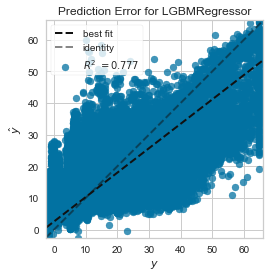

<AxesSubplot:title={'center':'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [17]:
visualizer = PredictionError(LGBMR_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [14]:
from sklearn.inspection import permutation_importance

In [18]:
from yellowbrick.regressor import ResidualsPlot

C:\Users\rajes\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


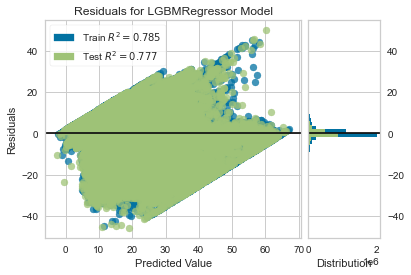

<AxesSubplot:title={'center':'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [19]:
visualizer = ResidualsPlot(LGBMR_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
visualizer.show()               # Finalize and render the figure

In [16]:
LGBMR_train_predict = LGBMR_model.predict(X_train)
LGBMR_validation_predict = LGBMR_model.predict(X_validation)

In [18]:
LGBMR_R2_train = r2_score(y_train,LGBMR_train_predict)
LGBMR_R2_validation = r2_score(y_validation,LGBMR_validation_predict)

LGBMR_MAPE_train = mean_absolute_percentage_error(y_train,LGBMR_train_predict)
LGBMR_MAPE_validation = mean_absolute_percentage_error(y_validation,LGBMR_validation_predict)

LGBMR_RMSE_train = sqrt(mean_squared_error(y_train,LGBMR_train_predict))
LGBMR_RMSE_validation =sqrt(mean_squared_error(y_validation,LGBMR_validation_predict))

In [19]:
resultsLGBMR = pd.DataFrame({'R Squared Score': LGBMR_R2_validation,
                          'MAPE Score':LGBMR_MAPE_validation,
                            'RMSE Score':LGBMR_RMSE_validation}
                           ,index=['Light Gradient Boosted Machine'])

results2 = pd.concat([resultsLGBMR,resultsLR])
results2

,R Squared Score,MAPE Score,RMSE Score
Light Gradient Boosted Machine,0.777182,0.253773,3.829396
Linear Regression,0.384116,0.488537,6.366561


**XGBoost Regressor**

In [16]:
XGB_model = XGBRegressor(n_estimators=2151,max_depth=10)
XGB_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2151,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
!pip install shap

In [17]:
from sklearn.inspection import permutation_importance

In [19]:
XGB_model.feature_importances_

array([0.02181114, 0.11967605, 0.1328032 , 0.5523614 , 0.10726143,
       0.06608687], dtype=float32)

In [32]:
feat_imp = pd.DataFrame({ 
    'Feature_Name' : X.columns,
    'Feature_Importance' : XGB_model.feature_importances_
})
feat_imp.sort_values('Feature_Importance', ascending = False)

,Feature_Name,Feature_Importance
3,time_step,0.552361
2,C,0.132803
1,R,0.119676
4,u_in,0.107261
5,u_out,0.066087
0,breath_id,0.021811


<AxesSubplot:ylabel='Feature_Name'>

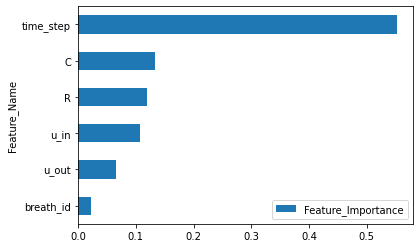

In [33]:
feat_imp.sort_values('Feature_Importance').plot.barh('Feature_Name', 'Feature_Importance')

In [ ]:
plt.barh(train.feature_names, xgb.feature_importances_)

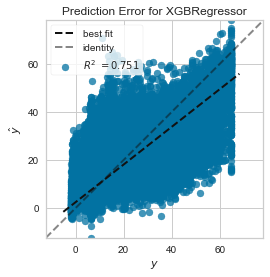

<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [25]:
visualizer = PredictionError(XGB_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

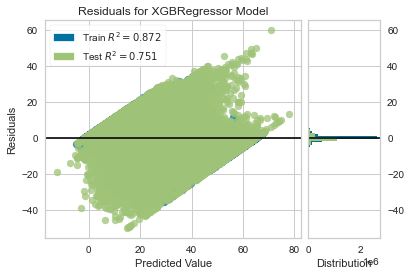

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [26]:
visualizer = ResidualsPlot(XGB_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
visualizer.show()               # Finalize and render the figure

In [37]:
XGB_train_predict = XGB_model.predict(X_train)
XGB_validation_predict = XGB_model.predict(X_validation)

In [38]:
XGB_R2_train = r2_score(y_train,XGB_train_predict)
XGB_R2_validation = r2_score(y_validation,XGB_validation_predict)

XGB_MAPE_train = mean_absolute_percentage_error(y_train,XGB_train_predict)
XGB_MAPE_validation = mean_absolute_percentage_error(y_validation,XGB_validation_predict)

XGB_RMSE_train = sqrt(mean_squared_error(y_train,XGB_train_predict))
XGB_RMSE_validation = sqrt(mean_squared_error(y_validation,XGB_validation_predict))

In [39]:
resultsXGB = pd.DataFrame({'R Squared Score': XGB_R2_validation,
                          'MAPE Score':XGB_MAPE_validation,
                          'RMSE Score':XGB_RMSE_validation}
                           ,index=['XGBoost Regressor'])

results3 = pd.concat([resultsXGB,results2])
results3

,R Squared Score,MAPE Score,RMSE Score
XGBoost Regressor,0.750880,0.247958,4.049111
Light Gradient Boosted Machine,0.777182,0.253773,3.829396
Linear Regression,0.384116,0.488537,6.366561


**Scoring Metrics**


**Random Forest Regressor**

In [49]:
rf=RandomForestRegressor(n_estimators = 500, max_depth = 10, random_state = 42)

In [ ]:
rf.fit(X_train, y_train)

In [43]:
rf.feature_importances_

array([8.96779742e-05, 4.06563585e-02, 4.34993859e-02, 8.02349996e-01,
       1.13404170e-01, 4.11063301e-07])

In [44]:
feat_imp = pd.DataFrame({ 
    'Feature_Name' : X.columns,
    'Feature_Importance' : rf.feature_importances_
})
feat_imp.sort_values('Feature_Importance', ascending = False)

,Feature_Name,Feature_Importance
3,time_step,8.023500e-01
4,u_in,1.134042e-01
2,C,4.349939e-02
1,R,4.065636e-02
0,breath_id,8.967797e-05
5,u_out,4.110633e-07


<AxesSubplot:ylabel='Feature_Name'>

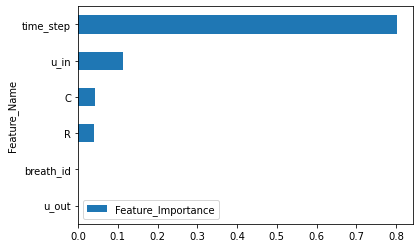

In [45]:
feat_imp.sort_values('Feature_Importance').plot.barh('Feature_Name', 'Feature_Importance')

In [46]:
RF_train_predict = rf.predict(X_train)
RF_validation_predict=rf.predict(X_validation)

In [47]:
RF_R2_train = r2_score(y_train,RF_train_predict)
RF_R2_validation = r2_score(y_validation,RF_validation_predict)

RF_MAPE_train = mean_absolute_percentage_error(y_train,RF_train_predict)
RF_MAPE_validation = mean_absolute_percentage_error(y_validation,RF_validation_predict)

RF_RMSE_train = sqrt(mean_squared_error(y_train,RF_train_predict))
RF_RMSE_validation = sqrt(mean_squared_error(y_validation,RF_validation_predict))

In [48]:
resultsRF = pd.DataFrame({'R Squared Score': RF_R2_validation,
                          'MAPE Score':RF_MAPE_validation,
                          'RMSE Score':RF_RMSE_validation}
                           ,index=['RandomForest Regressor'])

results4 = pd.concat([resultsRF,results3])
results4

,R Squared Score,MAPE Score,RMSE Score
RandomForest Regressor,0.746803,0.273719,4.082108
XGBoost Regressor,0.750880,0.247958,4.049111
Light Gradient Boosted Machine,0.777182,0.253773,3.829396
Linear Regression,0.384116,0.488537,6.366561


In [ ]:
visualizer = PredictionError(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [ ]:
visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
visualizer.show()               # Finalize and render the figure

## PART - II **LGBM Model Finalization after FE**

In [1]:
import os
os.getcwd()

'C:\\Users\\rajes\\Desktop\\BYOP Group I'

In [2]:
path = 'C:\\Users\\rajes\\Desktop\\BYOP Group I'

In [5]:
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))

In [6]:
print(set(test['breath_id'].unique()).intersection(set(train['breath_id'].unique())))
print(set(train['breath_id'].unique()).intersection(set(test['breath_id'].unique())))

set()
set()


## Feature Engineering

In [7]:
train['last_value_u_in'] = train.groupby('breath_id')['u_in'].transform('last')
train['u_in_lag1'] = train.groupby('breath_id')['u_in'].shift(1)
train['u_out_lag1'] = train.groupby('breath_id')['u_out'].shift(1)
train['u_in_lag_back1'] = train.groupby('breath_id')['u_in'].shift(-1)
train['u_out_lag_back1'] = train.groupby('breath_id')['u_out'].shift(-1)
train['u_in_lag2'] = train.groupby('breath_id')['u_in'].shift(2)
train['u_out_lag2'] = train.groupby('breath_id')['u_out'].shift(2)
train['u_in_lag_back2'] = train.groupby('breath_id')['u_in'].shift(-2)
train['u_out_lag_back2'] = train.groupby('breath_id')['u_out'].shift(-2)
train['u_in_lag3'] = train.groupby('breath_id')['u_in'].shift(3)
train['u_out_lag3'] = train.groupby('breath_id')['u_out'].shift(3)
train['u_in_lag_back3'] = train.groupby('breath_id')['u_in'].shift(-3)
train['u_out_lag_back3'] = train.groupby('breath_id')['u_out'].shift(-3)
train = train.fillna(0)


train['R__C'] = train["R"].astype(str) + '__' + train["C"].astype(str)

# max value of u_in and u_out for each breath
train['breath_id__u_in__max'] = train.groupby(['breath_id'])['u_in'].transform('max')
train['breath_id__u_out__max'] = train.groupby(['breath_id'])['u_out'].transform('max')

# difference between consequitive values
train['u_in_diff1'] = train['u_in'] - train['u_in_lag1']
train['u_out_diff1'] = train['u_out'] - train['u_out_lag1']
train['u_in_diff2'] = train['u_in'] - train['u_in_lag2']
train['u_out_diff2'] = train['u_out'] - train['u_out_lag2']

train.loc[train['time_step'] == 0, 'u_in_diff'] = 0
train.loc[train['time_step'] == 0, 'u_out_diff'] = 0

# difference between the current value of u_in and the max value within the breath
train['breath_id__u_in__diffmax'] = train.groupby(['breath_id'])['u_in'].transform('max') - train['u_in']
train['breath_id__u_in__diffmean'] = train.groupby(['breath_id'])['u_in'].transform('mean') - train['u_in']

# OHE
train = train.merge(pd.get_dummies(train['R'], prefix='R'), left_index=True, right_index=True).drop(['R'], axis=1)
train = train.merge(pd.get_dummies(train['C'], prefix='C'), left_index=True, right_index=True).drop(['C'], axis=1)
train = train.merge(pd.get_dummies(train['R__C'], prefix='R__C'), left_index=True, right_index=True).drop(['R__C'], axis=1)


train['u_in_cumsum'] = train.groupby(['breath_id'])['u_in'].cumsum()
train['time_step_cumsum'] = train.groupby(['breath_id'])['time_step'].cumsum()

In [17]:
train.head()

,id,breath_id,time_step,u_in,u_out,pressure,last_value_u_in,u_in_lag1,u_out_lag1,u_in_lag_back1,...,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50,u_in_cumsum,time_step_cumsum
0,1,1,0.000000,0.083334,0,5.837492,4.987079,0.000000,0.0,18.383041,...,0,1,0,0,0,0,0,0,0.083334,0.000000
1,2,1,0.033652,18.383041,0,5.907794,4.987079,0.083334,0.0,22.509278,...,0,1,0,0,0,0,0,0,18.466375,0.033652
2,3,1,0.067514,22.509278,0,7.876254,4.987079,18.383041,0.0,22.808822,...,0,1,0,0,0,0,0,0,40.975653,0.101167
3,4,1,0.101542,22.808822,0,11.742872,4.987079,22.509278,0.0,25.355850,...,0,1,0,0,0,0,0,0,63.784476,0.202709
4,5,1,0.135756,25.355850,0,12.234987,4.987079,22.808822,0.0,27.259866,...,0,1,0,0,0,0,0,0,89.140326,0.338464


In [8]:
# all the same for the test data
test['last_value_u_in'] = test.groupby('breath_id')['u_in'].transform('last')
test['u_in_lag1'] = test.groupby('breath_id')['u_in'].shift(1)
test['u_out_lag1'] = test.groupby('breath_id')['u_out'].shift(1)
test['u_in_lag_back1'] = test.groupby('breath_id')['u_in'].shift(-1)
test['u_out_lag_back1'] = test.groupby('breath_id')['u_out'].shift(-1)
test['u_in_lag2'] = test.groupby('breath_id')['u_in'].shift(2)
test['u_out_lag2'] = test.groupby('breath_id')['u_out'].shift(2)
test['u_in_lag_back2'] = test.groupby('breath_id')['u_in'].shift(-2)
test['u_out_lag_back2'] = test.groupby('breath_id')['u_out'].shift(-2)
test['u_in_lag3'] = test.groupby('breath_id')['u_in'].shift(3)
test['u_out_lag3'] = test.groupby('breath_id')['u_out'].shift(3)
test['u_in_lag_back3'] = test.groupby('breath_id')['u_in'].shift(-3)
test['u_out_lag_back3'] = test.groupby('breath_id')['u_out'].shift(-3)
test = test.fillna(0)
test['R__C'] = test["R"].astype(str) + '__' + test["C"].astype(str)

test['breath_id__u_in__max'] = test.groupby(['breath_id'])['u_in'].transform('max')
test['breath_id__u_out__max'] = test.groupby(['breath_id'])['u_out'].transform('max')

test['u_in_diff1'] = test['u_in'] - test['u_in_lag1']
test['u_out_diff1'] = test['u_out'] - test['u_out_lag1']
test['u_in_diff2'] = test['u_in'] - test['u_in_lag2']
test['u_out_diff2'] = test['u_out'] - test['u_out_lag2']
test.loc[test['time_step'] == 0, 'u_in_diff'] = 0
test.loc[test['time_step'] == 0, 'u_out_diff'] = 0

test['breath_id__u_in__diffmax'] = test.groupby(['breath_id'])['u_in'].transform('max') - test['u_in']
test['breath_id__u_in__diffmean'] = test.groupby(['breath_id'])['u_in'].transform('mean') - test['u_in']

test = test.merge(pd.get_dummies(test['R'], prefix='R'), left_index=True, right_index=True).drop(['R'], axis=1)
test = test.merge(pd.get_dummies(test['C'], prefix='C'), left_index=True, right_index=True).drop(['C'], axis=1)
test = test.merge(pd.get_dummies(test['R__C'], prefix='R__C'), left_index=True, right_index=True).drop(['R__C'], axis=1)

test['u_in_cumsum'] = test.groupby(['breath_id'])['u_in'].cumsum()
test['time_step_cumsum'] = test.groupby(['breath_id'])['time_step'].cumsum()

In [18]:
test.head()

,id,breath_id,time_step,u_in,u_out,last_value_u_in,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,...,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50,u_in_cumsum,time_step_cumsum
0,1,0,0.000000,0.000000,0,4.973375,0.000000,0.0,7.515046,0.0,...,0,0,0,0,0,0,1,0,0.000000,0.000000
1,2,0,0.031904,7.515046,0,4.973375,0.000000,0.0,14.651675,0.0,...,0,0,0,0,0,0,1,0,7.515046,0.031904
2,3,0,0.063827,14.651675,0,4.973375,7.515046,0.0,21.230610,0.0,...,0,0,0,0,0,0,1,0,22.166721,0.095731
3,4,0,0.095751,21.230610,0,4.973375,14.651675,0.0,26.320956,0.0,...,0,0,0,0,0,0,1,0,43.397331,0.191482
4,5,0,0.127644,26.320956,0,4.973375,21.230610,0.0,30.486938,0.0,...,0,0,0,0,0,0,1,0,69.718287,0.319126


## LGBM model Selection for final Predection after FE 

In [9]:
from sklearn.model_selection import GroupKFold
from sklearn import metrics
import time

In [10]:
scores = []
feature_importance = pd.DataFrame()
models = []
columns = [col for col in train.columns if col not in ['id', 'breath_id', 'pressure']]
X = train[columns]
y = train['pressure']

In [11]:
params = {'objective': 'regression',
          'learning_rate': 0.3,
          "boosting_type": "gbdt",
          "metric": 'mae',
          'n_jobs': -1,
          'min_data_in_leaf':32,
          'num_leaves':1024,
         }

In [12]:
folds = GroupKFold(n_splits=5)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train, y, groups=train['breath_id'])):
    print(f'Fold {fold_n} started at {time.ctime()}')
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    model = lgb.LGBMRegressor(**params, n_estimators=10000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=1000, early_stopping_rounds=15)
    score = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
    
    models.append(model)
    scores.append(score)

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

Fold 0 started at Mon Jul  4 11:13:33 2022


C:\Users\rajes\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rajes\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[1000]	training's l1: 0.195863	valid_1's l1: 0.364183
Fold 1 started at Mon Jul  4 11:18:09 2022


C:\Users\rajes\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rajes\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[1000]	training's l1: 0.19484	valid_1's l1: 0.364942
Fold 2 started at Mon Jul  4 11:23:27 2022


C:\Users\rajes\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rajes\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[1000]	training's l1: 0.194952	valid_1's l1: 0.365763
Fold 3 started at Mon Jul  4 11:29:01 2022


C:\Users\rajes\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rajes\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[1000]	training's l1: 0.195643	valid_1's l1: 0.363522
Fold 4 started at Mon Jul  4 11:36:00 2022


C:\Users\rajes\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rajes\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[1000]	training's l1: 0.195397	valid_1's l1: 0.365691


In [13]:
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

CV mean score: 0.3632, std: 0.0013.


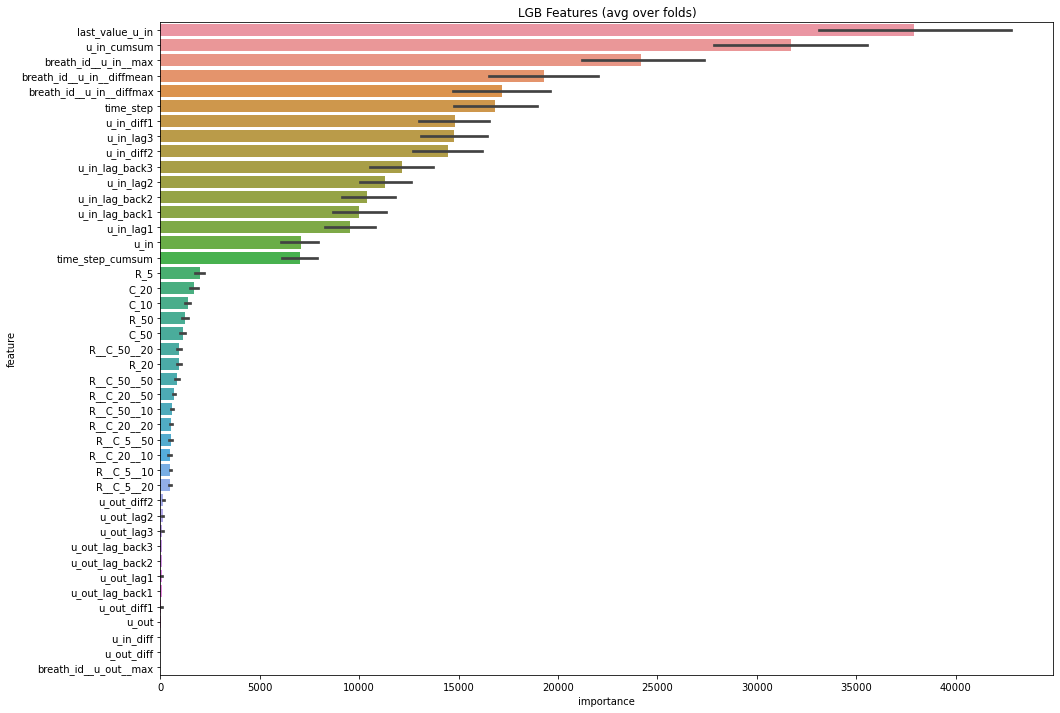

In [14]:
feature_importance["importance"] /= 5
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [15]:
for model in models:
    print(model)

LGBMRegressor(learning_rate=0.3, metric='mae', min_data_in_leaf=32,
              n_estimators=10000, num_leaves=1024, objective='regression')
LGBMRegressor(learning_rate=0.3, metric='mae', min_data_in_leaf=32,
              n_estimators=10000, num_leaves=1024, objective='regression')
LGBMRegressor(learning_rate=0.3, metric='mae', min_data_in_leaf=32,
              n_estimators=10000, num_leaves=1024, objective='regression')
LGBMRegressor(learning_rate=0.3, metric='mae', min_data_in_leaf=32,
              n_estimators=10000, num_leaves=1024, objective='regression')
LGBMRegressor(learning_rate=0.3, metric='mae', min_data_in_leaf=32,
              n_estimators=10000, num_leaves=1024, objective='regression')


In [16]:
LGBMR_train_predict = model.predict(X_train)
LGBMR_validation_predict = model.predict(X_valid)

In [34]:
LGBM_R2_train = r2_score(y_train,LGBMR_train_predict)
LGBM_R2_validation = r2_score(y_valid,LGBMR_validation_predict)

LGBM_MAPE_train = mean_absolute_percentage_error(y_train,LGBMR_train_predict)
LGBM_MAPE_validation =mean_absolute_percentage_error(y_valid,LGBMR_validation_predict)

LGBM_RMSE_train = sqrt(mean_squared_error(y_train,LGBMR_train_predict))
LGBM_RMSE_validation =sqrt(mean_squared_error(y_valid,LGBMR_validation_predict))

In [35]:
resultsLR = pd.DataFrame({'R Squared Score': LGBM_R2_validation,
                          'MAPE Score':LGBM_MAPE_validation,
                         'RMSE Score':LGBM_RMSE_validation}
                           ,index=['Light Gradient Boosted Machine'])

resultsLR

,R Squared Score,MAPE Score,RMSE Score
Light Gradient Boosted Machine,0.993824,0.038992,0.637521


In [36]:
from yellowbrick.regressor import PredictionError

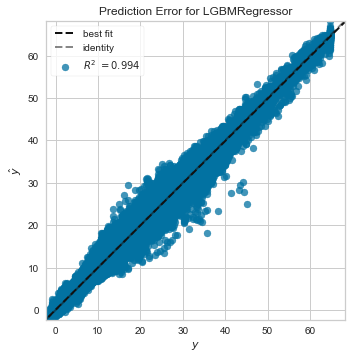

<AxesSubplot:title={'center':'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [37]:
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_valid, y_valid)  # Evaluate the model on the test data
visualizer.show()                 # Fit Show Map

In [38]:
from yellowbrick.regressor import ResidualsPlot

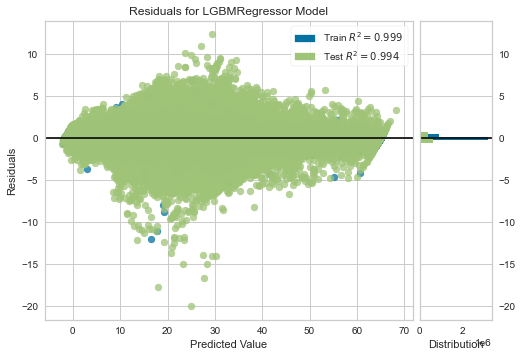

<AxesSubplot:title={'center':'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [39]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_valid, y_valid)  # Evaluate the model on the test data
visualizer.show()               # Finalize and render the figure

In [17]:
Final_Prediction = model.predict(test[columns])

In [43]:
Submission=pd.read_csv('Submission.csv')

In [44]:
Submission.pressure = Final_Prediction

<ipython-input-44-e10adf72f465>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Submission.pressure = Final_Prediction


In [45]:
Submission.head()

,6.479057205575613487e+00
0,6.059026
1,7.157465
2,7.899375
3,9.315924
4,10.344127
